In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16407269537927850618
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15520511293390624935
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 142459034451428969
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15848577434
locality {
  bus_id: 1
  links {
  }
}
incarnation: 146958499525841766
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [2]:
# To unzip the Train files
# import zipfile
# with zipfile.ZipFile('test-jpg.zip', 'r') as test_data:
#     test_data.extractall()

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2
import random

from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session
import tensorflow as tf

Will define the Hyper Parameters here

In [4]:
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
EPOCHS = 24
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 5 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

TRAIN_PATH = '/home/jupyter/train-jpg'
TEST_PATH = '/home/jupyter/test-jpg/test-jpg'

TRAIN_CSV_PATH = '/home/jupyter/train_v2.csv'
TEST_CSV_PATH = '/home/jupyter/sample_submission_v2.csv'

In [8]:
# Construct dataframes holding training and test data information
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

df_train.shape

(40479, 2)

In [10]:
df_train.head()

image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road

In [11]:
# These files are numpy Arrays with shape Nx1
X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist())

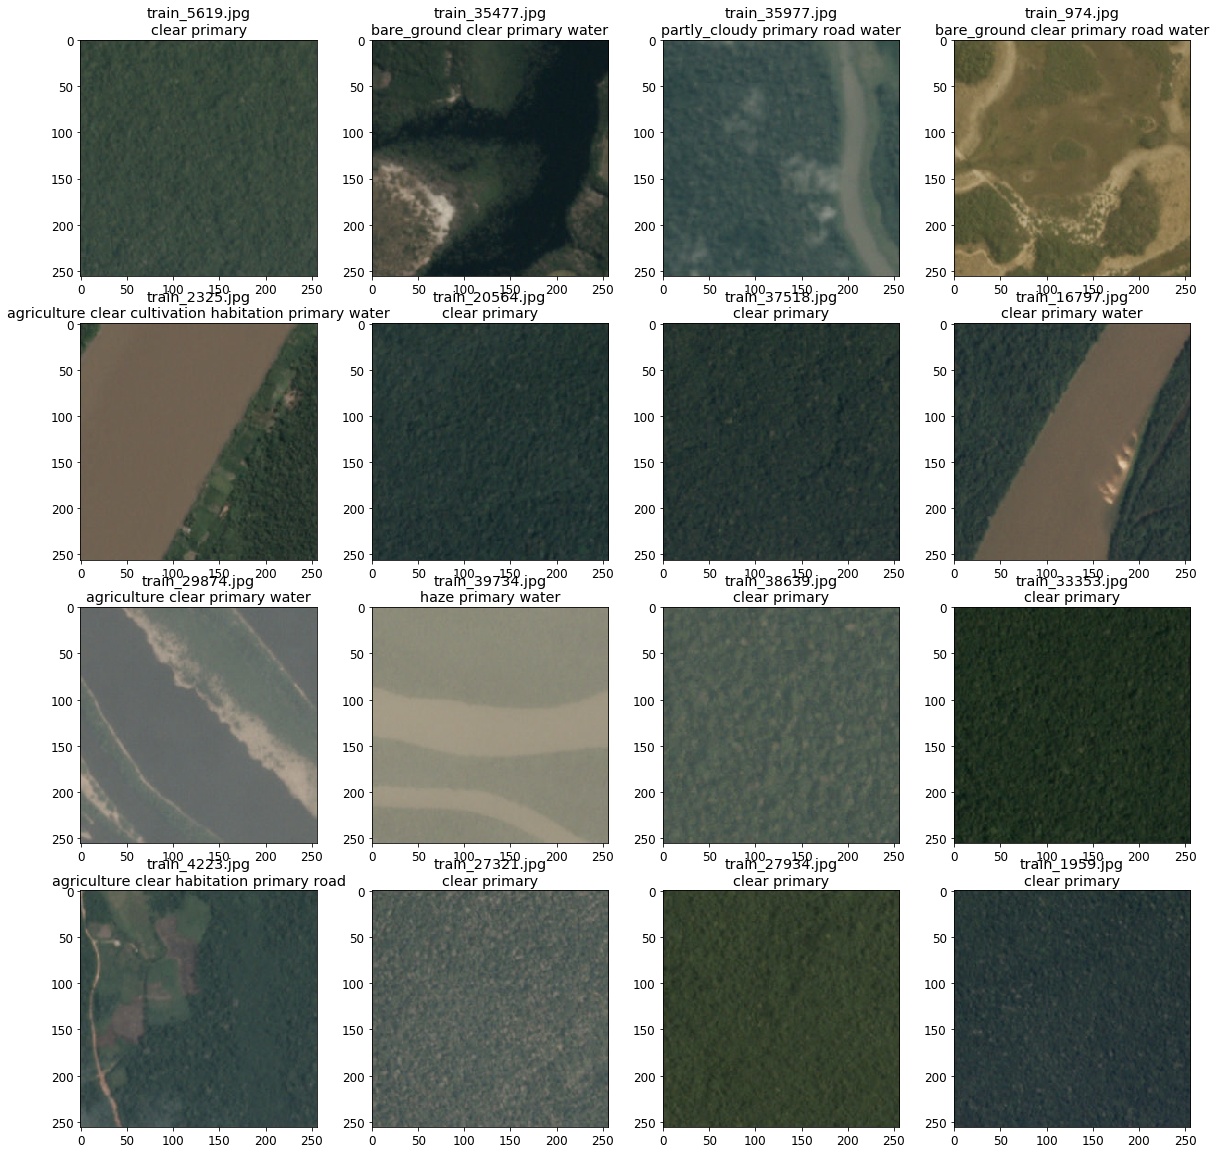

In [76]:
# View a few images
plt.rc('axes')
fig, ax = plt.subplots(4,4, figsize=(20,20))
random_imgs = np.random.randint(0,len(df_train),25)

count = 0
for i in range(4):
    for j in range(4):
        idx = random_imgs[count]
        img_name = df_train.iloc[idx].values[0]
        img_tag = df_train.iloc[idx].values[1]
        img = cv2.imread('/home/jupyter/train-jpg/{}'.format(img_name))
        ax[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i,j].set_title('{}\n{}'.format(img_name, img_tag))
        count += 1

#### We can see the difference between image resolution. We did this plot to identify which is the best resolution to take.
#### 32x32 seems very low. 128x128 resolution seems reasonable

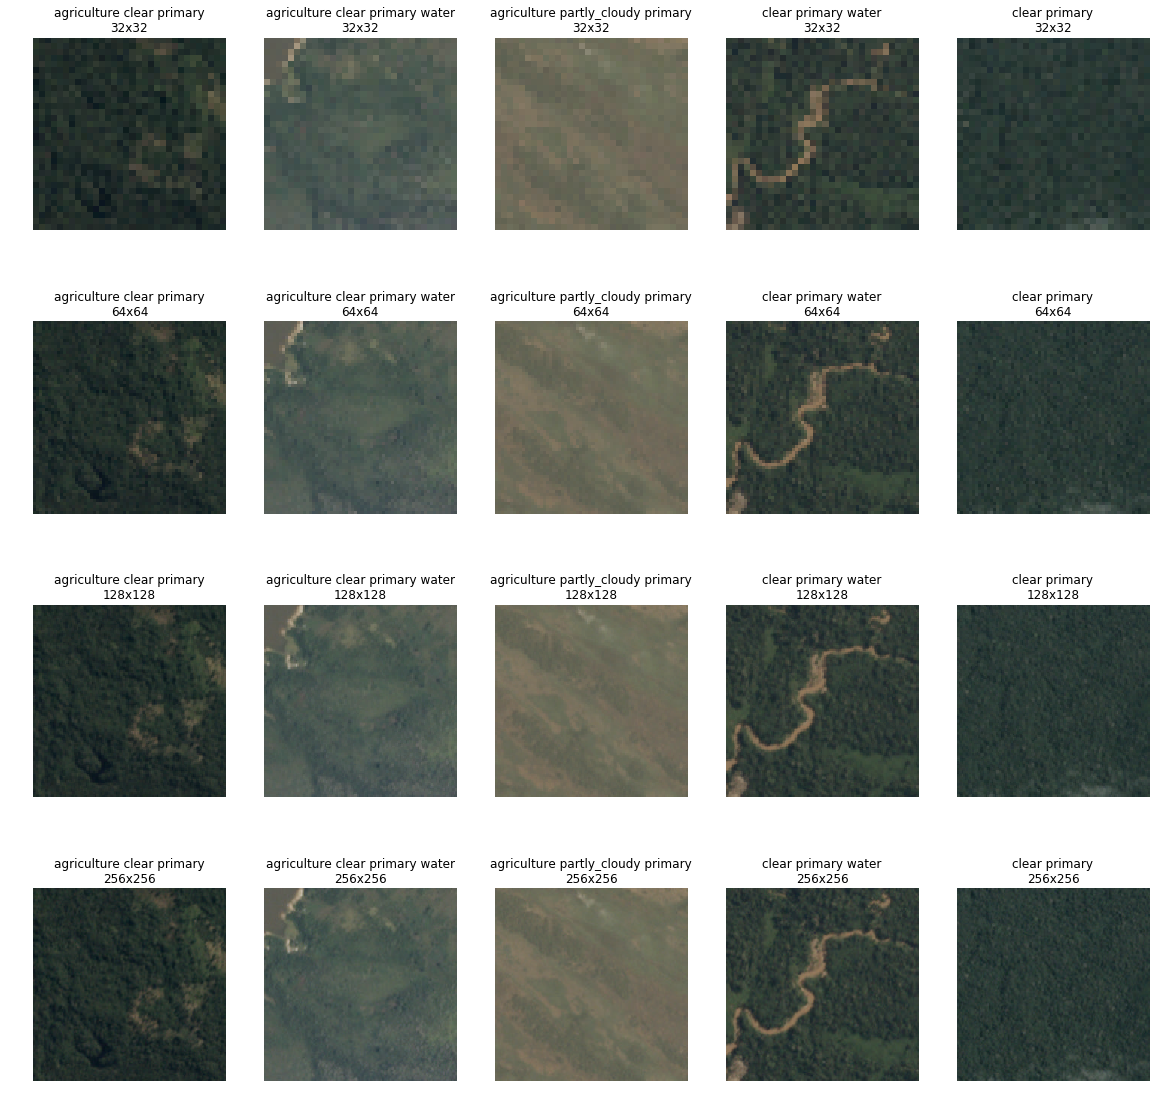

In [37]:
plt.figure(figsize=(20, 20))
res = [32, 64, 128, 256]

# Creating random 5 image indices to display 
img_idx = random.sample(range(40480), 5)

for i in range(len(res)):
    for j in range(len(img_idx)):
        img = cv2.imread(os.path.join(TRAIN_PATH, df_train['image_name'][img_idx[j]]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), len(img_idx), i*len(img_idx)+j+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(df_train['tags'][img_idx[j]] + "\n" + str(res[i]) + "x" + str(res[i]))
        plt.axis('off')    
plt.show()

In [40]:
# Dataframe to hold the label names and frequency
df_labelFreq = pd.DataFrame(list(labels_count.values()), index=labels_count.keys(), columns=['Frequency'])

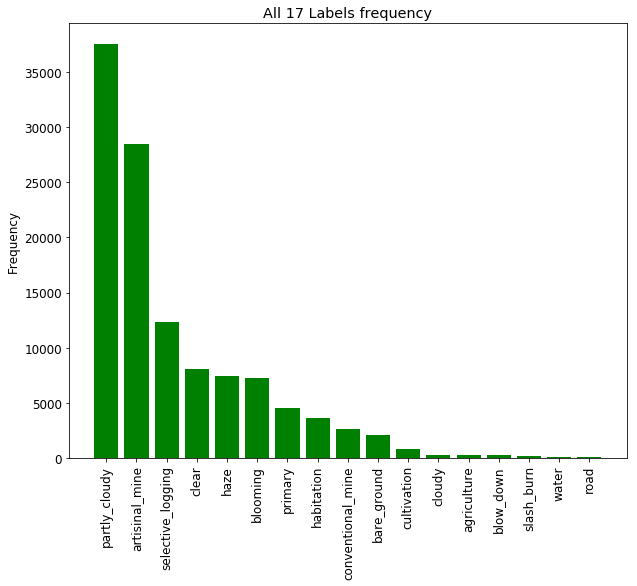

In [43]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 8))

# Dictionary to hold the label counts
labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
plt.bar(range(len(labels_count)), sorted(list(labels_count.values()), reverse=True), align='center', color='g')
plt.xticks(range(len(labels_count)), df_labelFreq.index.values, rotation=90)
plt.title('All 17 Labels frequency')
plt.ylabel('Frequency')
plt.show()

In [50]:
df_labelFreq.sort_values(by='Frequency', ascending=False)

Frequency
primary                37512
clear                  28430
agriculture            12314
road                    8070
water                   7410
partly_cloudy           7260
cultivation             4546
habitation              3659
haze                    2696
cloudy                  2088
bare_ground              861
selective_logging        339
artisinal_mine           338
blooming                 331
slash_burn               208
blow_down                100
conventional_mine         99

In [49]:
# Rare Labels (Count<1000)
df_labelFreq[df_labelFreq['Frequency'] <= 1000].sort_values(by='Frequency', ascending=False)

Frequency
bare_ground              861
selective_logging        339
artisinal_mine           338
blooming                 331
slash_burn               208
blow_down                100
conventional_mine         99

Text(0, 0.5, 'Frequency')

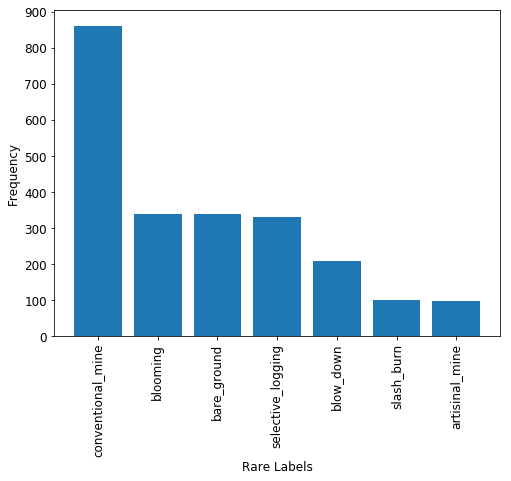

In [62]:
plt.figure(figsize=(8,6))
plt.bar(range(len(labels_count_rare)), sorted(list(labels_count_rare.values()), reverse=True), align='center')
plt.xticks(range(len(labels_count_rare)), list(labels_count_rare.keys()), rotation=90)
plt.yticks(range(0,1000,100))
plt.xlabel('Rare Labels')
plt.ylabel('Frequency')

#### Transfer learning model - VGG16

In [11]:
def create_model():
    model = Sequential()
    model.add(InputLayer(INPUT_SHAPE))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(DROPOUT_RATE))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(17, activation='sigmoid'))
    return model

clear_session()
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                139281    
Total params: 14,853,969
Trainable params: 14,853,969
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Custom fbeta metrics for evaluation
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [18]:
# 5 fold cross validation
num_fold = 5 

# List to hold the 5 sets of output proabailities from the 5-fold cross validation  
y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)
for train_index, val_index in folds:
    # 
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    # Image Augumentation and scaling the features.
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    # Path to save the model
    model_path_of_fold = os.path.join('', '2 - Re-run fold-' + str(num_fold) + '.h5')
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, save_weights_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)

    
    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)
    y_test.append(p_test)
    num_fold += 1

Found 32383 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Found 61191 validated image filenames belonging to 17 classes.
Epoch 1/24
253/253 [==============================] - 280s 1s/step - loss: 0.1538 - f2_score: 0.8059 - val_loss: 0.1184 - val_f2_score: 0.8521
Epoch 2/24
253/253 [==============================] - 114s 450ms/step - loss: 0.1165 - f2_score: 0.8619 - val_loss: 0.1062 - val_f2_score: 0.8767
Epoch 3/24
253/253 [==============================] - 113s 447ms/step - loss: 0.1085 - f2_score: 0.8723 - val_loss: 0.1013 - val_f2_score: 0.8825
Epoch 4/24
253/253 [==============================] - 112s 444ms/step - loss: 0.1048 - f2_score: 0.8769 - val_loss: 0.0995 - val_f2_score: 0.8928
Epoch 5/24
253/253 [==============================] - 113s 445ms/step - loss: 0.1008 - f2_score: 0.8835 - val_loss: 0.0971 - val_f2_score: 0.8980
Epoch 6/24
253/253 [==============================] - 111s 440ms/step - loss: 0.0991 

In [19]:
# Test image probabilities converted to data Frame
result = np.array(y_test[0])

# Averaging the results from the 5 cross validations
for i in range(1, NFOLDS):
    result += np.array(y_test[i])
result /= NFOLDS
result = pd.DataFrame(result, columns = labels)
result.head()

agriculture  artisinal_mine  bare_ground  blooming  blow_down     clear  \
0     0.008728        0.000006     0.000122  0.076126   0.000598  0.993415   
1     0.019039        0.000005     0.000219  0.018168   0.005389  0.997544   
2     0.022863        0.000007     0.000198  0.000174   0.000684  0.000079   
3     0.676887        0.000051     0.002271  0.011054   0.000557  0.935307   
4     0.012487        0.000004     0.000218  0.000008   0.000050  0.000931   

         cloudy  conventional_mine  cultivation  habitation      haze  \
0  1.841784e-06           0.000002     0.005089    0.001727  0.000809   
1  2.801418e-07           0.000002     0.015180    0.001267  0.000072   
2  6.493330e-05           0.000021     0.007096    0.000770  0.000036   
3  7.510185e-07           0.000025     0.674894    0.005100  0.000739   
4  2.339951e-01           0.000006     0.004405    0.000748  0.001687   

   partly_cloudy   primary      road  selective_logging  slash_burn     water  
0       0.003336  0.999993  0.003640           0.007036    0.000076  0.006290  
1       0.001981  0.999998  0.001333           0.002717    0.000113  0.002686  
2       0.999853  0.999936  0.004910           0.000207    0.000044  0.027746  
3       0.089646  0.999997  0.015385           0.003018    0.001803  0.037564  
4       0.827825  0.791905  0.005715           0.000019    0.000012  0.023027

#### Threshold 0.2 KAGGLE SCORE - 0.92595

In [24]:
# Threshold 0.2 
# Kaggle Score 0.92595
preds = []
for i in range(result.shape[0]):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.to_csv('2 rerun - submit.csv', index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


#### Threshold 0.1 Kaggle Score 0.91728

In [40]:
THRES = 0.1
preds = []
for i in range(result.shape[0]):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.to_csv('2 rerun thresh 0.1 - submit.csv', index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


# Optional: Training dataset Prediction and evaluation
It is not needed for Kaggle Submission, but we did to evaluate the F1-score of the different tags
Note that you need to first get the predictions with the train data

In [65]:
# Function to load X and y as arrays from the raw images
def load_data(df_train, labels):
    X = []

    for img_name, tags in df_train.values:
        try:
            img = cv2.imread('train-jpg/{}'.format(img_name))
            X.append(cv2.resize(img, (128,128)))
        
        except Exception as e:
            print('Issue with loading', img_name)
            
    return X

In [ ]:
X = load_data(df_train, labels)
X = np.array(X).reshape(-1,128,128,3)
X = X/255.
y_pred = model.predict(X, batch_size=128)

In [41]:
df_pred = pd.DataFrame(y_pred, columns = labels)
train_preds = []
for i in range(df_pred.shape[0]):
    a = df_pred.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    train_preds.append(' '.join(list(a.index)))
    
# Import the predictions to csv
df_train['pred_tags'] = train_preds
df_train.to_csv('2 - rerun train_pred.csv', index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Function to return the binary encoding of 17 labels based on train prediction
def return_Binary(tags):
    tags = tags.split(' ')
    return [1 if x in tags else 0 for x in labels]

In [43]:
train_predictions = pd.read_csv('2 - rerun train_pred.csv')

train_predictions['pred_binary'] = train_predictions['pred_tags'].map(return_Binary)
train_predictions['actual_binary'] = train_predictions['tags'].map(return_Binary)

pred_toArray = np.array(list(train_predictions['pred_binary']))
actual_toArray = np.array(list(train_predictions['actual_binary']))

df_predBinary = pd.DataFrame(pred_toArray, columns=labels)
df_actualBinary = pd.DataFrame(actual_toArray, columns=labels)

pred_toArray = np.array(list(train_predictions['pred_binary']))
actual_toArray = np.array(list(train_predictions['actual_binary']))

df_predBinary = pd.DataFrame(pred_toArray, columns=labels)
df_actualBinary = pd.DataFrame(actual_toArray, columns=labels)

df_compare = pd.concat([df_actualBinary.sum(), df_predBinary.sum()], axis=1)
df_compare.columns = ['Actual Positives', 'Predicted Positives']
df_compare

Actual Positives  Predicted Positives
agriculture                   12315                10854
artisinal_mine                  339                    0
bare_ground                     862                   24
blooming                        332                  285
blow_down                        98                    0
clear                         28431                25610
cloudy                         2089                 2723
conventional_mine               100                    0
cultivation                    4477                  247
habitation                     3660                 5927
haze                           2697                 3837
partly_cloudy                  7261                17082
primary                       37513                38890
road                           8071                11142
selective_logging               340                    3
slash_burn                      209                    0
water                          7411                17948

In [44]:
print(classification_report(df_predBinary, df_actualBinary, target_names=labels))

                   precision    recall  f1-score   support

      agriculture       0.67      0.76      0.72     10854
   artisinal_mine       0.00      0.00      0.00         0
      bare_ground       0.01      0.50      0.03        24
         blooming       0.19      0.22      0.20       285
        blow_down       0.00      0.00      0.00         0
            clear       0.84      0.94      0.89     25610
           cloudy       0.90      0.69      0.78      2723
conventional_mine       0.00      0.00      0.00         0
      cultivation       0.04      0.76      0.08       247
       habitation       0.79      0.49      0.60      5927
             haze       0.78      0.55      0.64      3837
    partly_cloudy       0.97      0.41      0.58     17082
          primary       1.00      0.96      0.98     38890
             road       0.89      0.65      0.75     11142
selective_logging       0.00      0.33      0.01         3
       slash_burn       0.00      0.00      0.00       

In [35]:
train_predictions['pred_binary'] = train_predictions['pred_tags'].map(return_Binary)
train_predictions['actual_binary'] = train_predictions['tags'].map(return_Binary)

In [38]:
pred_toArray = np.array(list(train_predictions['pred_binary']))
actual_toArray = np.array(list(train_predictions['actual_binary']))

df_predBinary = pd.DataFrame(pred_toArray, columns=labels)
df_actualBinary = pd.DataFrame(actual_toArray, columns=labels)

pred_toArray = np.array(list(train_predictions['pred_binary']))
actual_toArray = np.array(list(train_predictions['actual_binary']))
df_predBinary = pd.DataFrame(pred_toArray, columns=labels)
df_actualBinary = pd.DataFrame(actual_toArray, columns=labels)

df_compare = pd.concat([df_actualBinary.sum(), df_predBinary.sum()], axis=1)
df_compare.columns = ['Actual Positives', 'Predicted Positives']
df_compare

Actual Positives  Predicted Positives
agriculture                   12315                10854
artisinal_mine                  339                    0
bare_ground                     862                   24
blooming                        332                  285
blow_down                        98                    0
clear                         28431                25610
cloudy                         2089                 2723
conventional_mine               100                    0
cultivation                    4477                  247
habitation                     3660                 5927
haze                           2697                 3837
partly_cloudy                  7261                17082
primary                       37513                38890
road                           8071                11142
selective_logging               340                    3
slash_burn                      209                    0
water                          7411                17948

In [39]:
print(classification_report(df_predBinary, df_actualBinary, target_names=labels))

                   precision    recall  f1-score   support

      agriculture       0.67      0.76      0.72     10854
   artisinal_mine       0.00      0.00      0.00         0
      bare_ground       0.01      0.50      0.03        24
         blooming       0.19      0.22      0.20       285
        blow_down       0.00      0.00      0.00         0
            clear       0.84      0.94      0.89     25610
           cloudy       0.90      0.69      0.78      2723
conventional_mine       0.00      0.00      0.00         0
      cultivation       0.04      0.76      0.08       247
       habitation       0.79      0.49      0.60      5927
             haze       0.78      0.55      0.64      3837
    partly_cloudy       0.97      0.41      0.58     17082
          primary       1.00      0.96      0.98     38890
             road       0.89      0.65      0.75     11142
selective_logging       0.00      0.33      0.01         3
       slash_burn       0.00      0.00      0.00       

Plot Loss

In [50]:
df = pd.read_csv('Loss.csv', header='infer')
df.head()

Train_Loss  Train_f2  Val_Loss  Val_f2
0      0.1641    0.7885    0.1297  0.8635
1      0.1181    0.8591    0.1058  0.8852
2      0.1112    0.8693    0.1120  0.8829
3      0.1050    0.8758    0.1061  0.8891
4      0.1029    0.8801    0.1056  0.8908

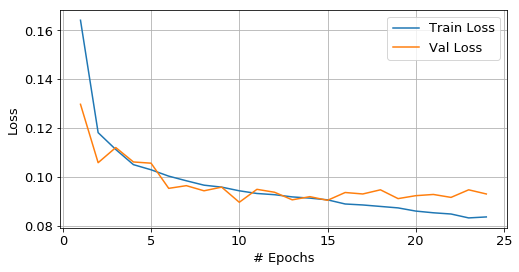

In [71]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,25), df['Train_Loss'], label='Train Loss')
plt.plot(np.arange(1,25), df['Val_Loss'], label='Val Loss')
plt.grid()
plt.legend()
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.show()

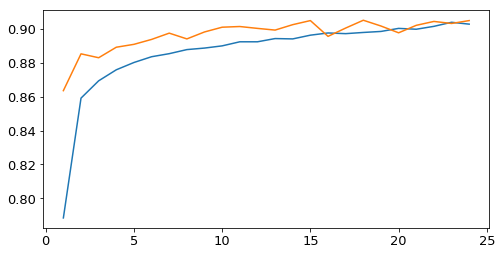

In [67]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1,25), df['Train_f2'])
plt.plot(np.arange(1,25), df['Val_f2'])
plt.show()

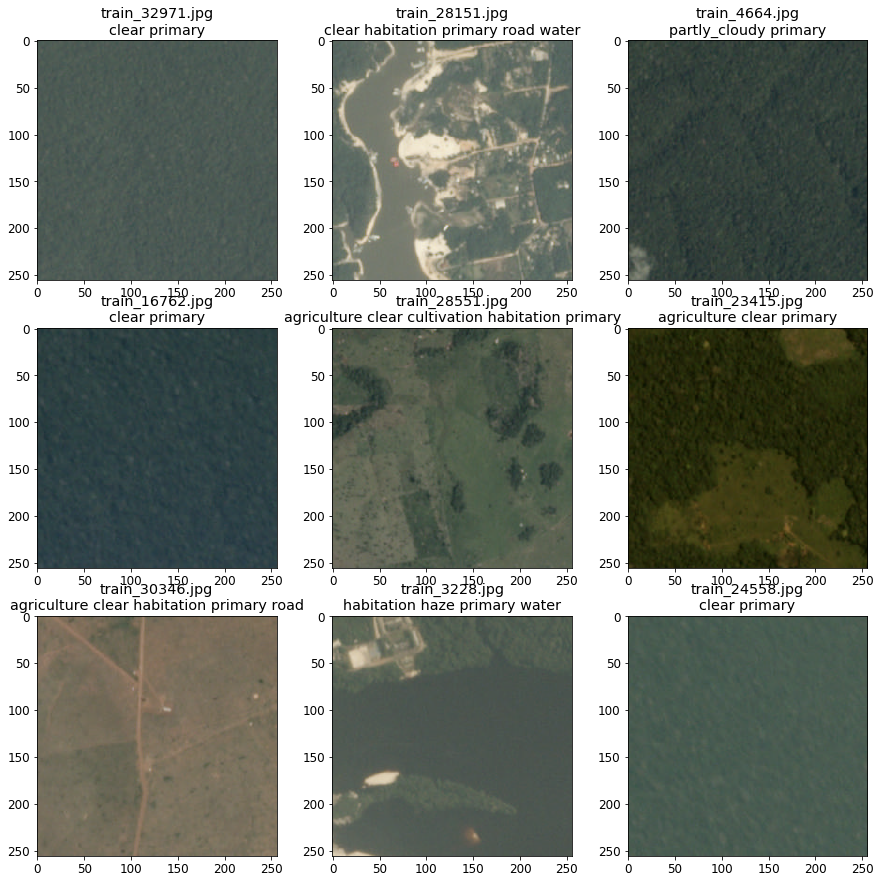

In [21]:
def show_image(index):
    image = cv2.imread('/home/jupyter/train-jpg/{}.jpg'.format('train_' + str(index)))
    plt.figure(figsize=(4.5,4.5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.imshow(image)
    f, l = df_train.iloc[index].values
    plt.title('{} - {}'.format(f, l))

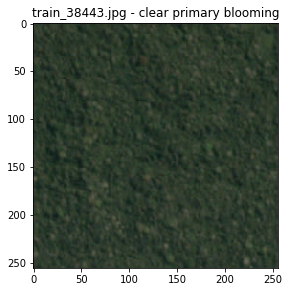

In [23]:
show_image(38443)

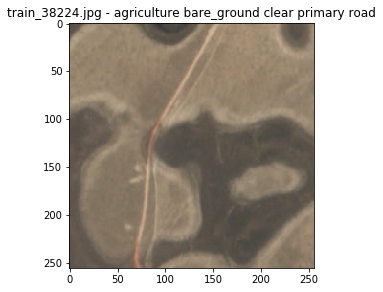

In [11]:
show_image(38224)

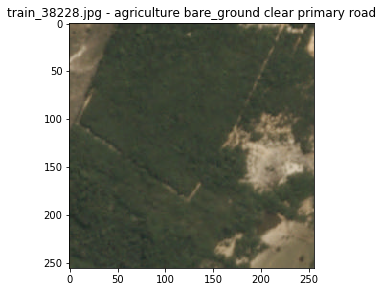

In [12]:
show_image(38228)